## Extract and modify molecules information and labels from PubChem assay No. 1851

#### Load required packages

In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
import os
import csv
from urllib.request import urlopen, HTTPError
import math
from time import sleep

import numpy as np
import pandas as pd
import rdkit
from tqdm import tqdm, tqdm_notebook
from rdkit.Chem import inchi
from rdkit.Chem import MolFromSmiles, MolToSmiles
from rdkit.Chem.rdMolDescriptors import GetMorganFingerprintAsBitVect

from utils.label_convertors import multilabel2onehot

#### Path to the raw data file

In [2]:
raw_data_path = os.path.join("..", "data", "AID_1851_datatable_raw_data.csv")

#### Read the raw data

In [3]:
raw_df = pd.read_csv(raw_data_path, header=0, skiprows=list(range(1,9)))

C:\Users\thoma\AppData\Local\conda\conda\envs\playground\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
raw_df.columns

Index(['PUBCHEM_RESULT_TAG', 'PUBCHEM_SID', 'PUBCHEM_CID',
       'PUBCHEM_ACTIVITY_OUTCOME', 'PUBCHEM_ACTIVITY_SCORE',
       'PUBCHEM_ACTIVITY_URL', 'PUBCHEM_ASSAYDATA_COMMENT',
       'Inhibition Observed', 'Approved Drug', 'Collection',
       ...
       'p450-cyp2c9-Activity at 0.091 uM', 'p450-cyp2c9-Activity at 0.204 uM',
       'p450-cyp2c9-Activity at 0.457 uM', 'p450-cyp2c9-Activity at 1.022 uM',
       'p450-cyp2c9-Activity at 2.286 uM', 'p450-cyp2c9-Activity at 5.111 uM',
       'p450-cyp2c9-Activity at 11.43 uM', 'p450-cyp2c9-Activity at 25.56 uM',
       'p450-cyp2c9-Activity at 57.14 uM', 'Compound QC'],
      dtype='object', length=147)

### Entries have SID but not CID

In [5]:
counter = 0
for i, cid in enumerate(raw_df["PUBCHEM_CID"].tolist()):
    try:
        int(cid)
    except ValueError:
        counter += 1
        print(raw_df.iloc[i][["PUBCHEM_CID", "PUBCHEM_SID"]])
print("total: %d" % counter)

PUBCHEM_CID        NaN
PUBCHEM_SID    4252974
Name: 5367, dtype: object
PUBCHEM_CID        NaN
PUBCHEM_SID    4253080
Name: 5470, dtype: object
PUBCHEM_CID        NaN
PUBCHEM_SID    4253090
Name: 5480, dtype: object
PUBCHEM_CID        NaN
PUBCHEM_SID    4253551
Name: 5925, dtype: object
PUBCHEM_CID        NaN
PUBCHEM_SID    4253935
Name: 6302, dtype: object
PUBCHEM_CID        NaN
PUBCHEM_SID    4253936
Name: 6303, dtype: object
PUBCHEM_CID        NaN
PUBCHEM_SID    4253937
Name: 6304, dtype: object
PUBCHEM_CID        NaN
PUBCHEM_SID    4253938
Name: 6305, dtype: object
PUBCHEM_CID        NaN
PUBCHEM_SID    4253939
Name: 6306, dtype: object
PUBCHEM_CID        NaN
PUBCHEM_SID    4253940
Name: 6307, dtype: object
PUBCHEM_CID        NaN
PUBCHEM_SID    4254023
Name: 6387, dtype: object
PUBCHEM_CID        NaN
PUBCHEM_SID    4254027
Name: 6391, dtype: object
PUBCHEM_CID        NaN
PUBCHEM_SID    4254028
Name: 6392, dtype: object
PUBCHEM_CID        NaN
PUBCHEM_SID    4254041
Name: 6405, dtype:

In [6]:
def get_smiles(cid_list, chunk_size=100):
    """ Retrieve isomeric_SMILES from PubChem by CID
    cid_list: list of cid
    chunk_size: number of cids in one request
    =========================================
    return: dataframe converted from the responses
    """
    request = list()
    n_chunks = int(math.ceil(len(cid_list) / chunk_size))
    responses = list()
    for i in tqdm_notebook(range(n_chunks)):
        c_start = i * chunk_size
        c_end = min(len(cid_list), (i+1)*chunk_size)
        responsed = False
        while not responsed:
            try:
                with urlopen(
                        "https://pubchem.ncbi.nlm.nih.gov/rest/pug/"
                        "compound/cid/{}/property/IsomericSMILES/"
                        "csv".format(
                            ",".join(map(str, cid_list[c_start:c_end])))
                        ) as response:
                    responses.append(pd.read_csv(response))
                responsed = True
            except HTTPError:
                sleep(1)
    df = pd.concat(responses)
    return df

### Plot different classes of entries in the raw data

In [7]:
import matplotlib
matplotlib.use("nbagg")
import matplotlib.pyplot as plt

In [8]:
def plot(data_list):
    """ Function to plot the activity curves in the raw data
    data_list: list of activity assay values
    ======================
    return: the matplotlib figure
    """
    fig, axes = plt.subplots(nrows=1, ncols=len(data_list), figsize=[9.6, 4.8])
    for idx, ax in enumerate(axes):
        y = data_list[idx].split("\t")
        y = list(map(str.strip, y))
        y = list(map(float, y))
        x = list(range(len(y)))
        ax.plot(x, y)
        ax.set_xlim(0, 15)
    fig.text(0.5, 0.02, 'Time Points', ha='center')
    fig.text(0.07, 0.5, 'Activity Value', va='center', rotation='vertical')
    return fig

### Active (CID: 24360,  132846, 6603727)

<IPython.core.display.Javascript object>


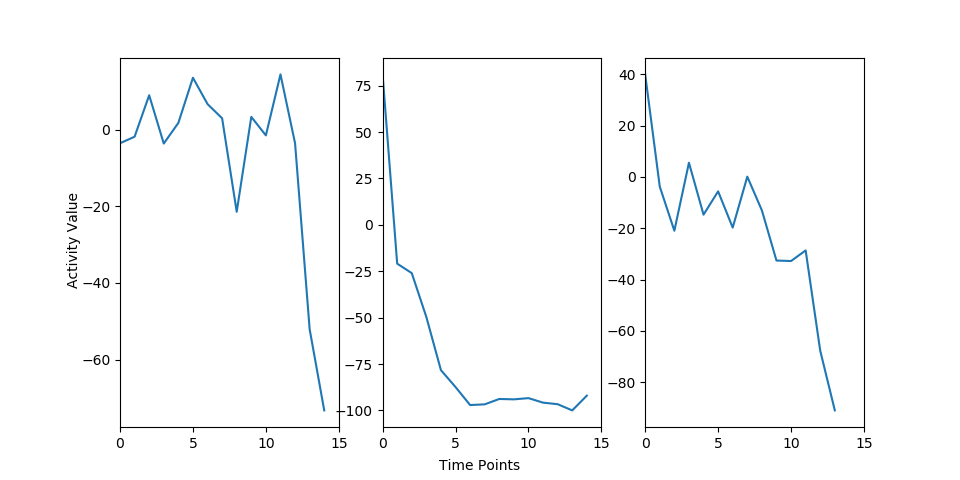

In [9]:
y1 = "-3.553	-1.851	8.973	-3.633	1.761	13.54	6.667	2.958	-21.43	3.325	-1.504	14.41	-3.543	-52.08	-73.26"
y2 = "81.06	-20.89	-25.99	-49.66	-78.27	-87.37	-97.07	-96.69	-93.79	-94	-93.34	-95.77	-96.61	-99.95	-92.01"
y3 = "39.92	-3.799	-20.99	5.509	-14.73	-5.649	-19.77	0.0816	-13.05	-32.6	-32.79	-28.66	-67.75	-90.99"
fig1 = plot([y1, y2, y3])
plt.show()

### Inactive (CID: 197584, 135484656, 3410883)

<IPython.core.display.Javascript object>


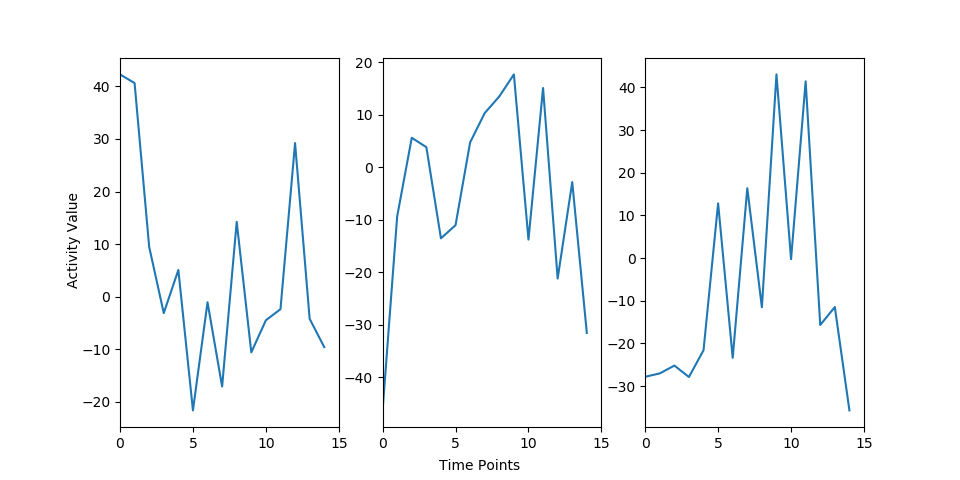

In [10]:
y4 = "42.26	40.61	9.476	-3.114	5.082	-21.61	-1.053	-17.07	14.24	-10.58	-4.474	-2.372	29.21	-4.196	-9.582"
y5 = "-46.29	-9.325	5.643	3.86	-13.51	-11.01	4.757	10.35	13.52	17.72	-13.75	15.13	-21.17	-2.798	-31.53"
y6 = "-27.83	-27.04	-25.2	-27.88	-21.6	12.83	-23.39	16.37	-11.54	43.05	-0.2592	41.42	-15.69	-11.48	-35.71"
fig2 = plot([y4, y5, y6])
plt.show()

### Inconclusive (CID: 6604015, 6604810, 6604808)

<IPython.core.display.Javascript object>


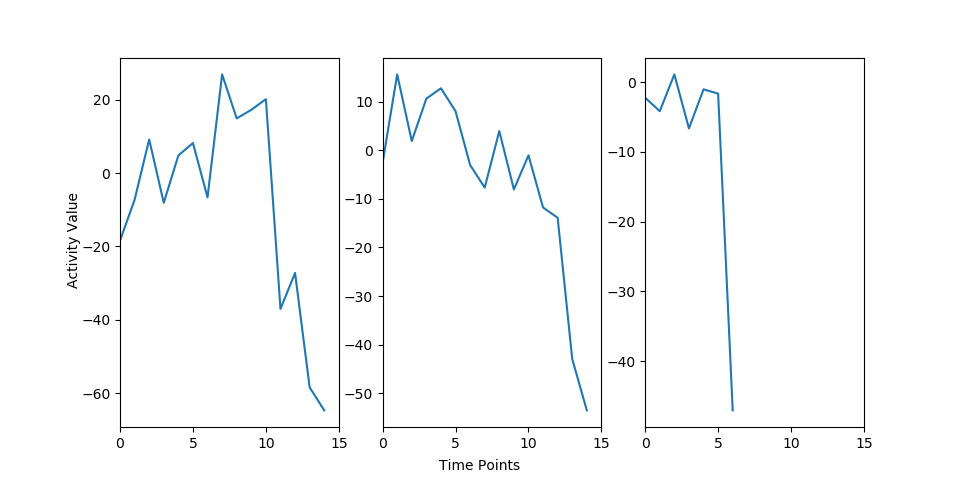

In [11]:
y7 = "-18.41	-7.278	9.187	-8.096	4.81	8.208	-6.628	26.93	14.92	17.27	20.17	-37.04	-27.24	-58.45	-64.73"
y8 = "-2.587	15.6	1.886	10.62	12.74	8.03	-3.038	-7.694	3.94	-8.068	-1.047	-11.78	-13.89	-42.95	-53.52"
y9 = "20.12	7.071	6.571	9.289	0.5662	22.73	-7.393	-6.562	6.081	8.132	3.462	-14.89	-22.13	-53.11	-57.31"
y10 = "31.76	-0.0348	-20.61	-14.31	-11.79	15.1	-14.82	9.915	-17.57	16.6	-9.95	-14.59	-46.84	-48.18	-65.61"
y11 = "3.2652	4.7504	3.6598	-6.0335	-46.8656"
y12 = "-2.2225	-4.1569	1.121	-6.6281	-1.0204	-1.6375	-47.0862"
fig3 = plot([y7, y8, y12])
fig3.show()

Confilct in Hansaim's raw data (integrated_binary_activity.tsv)  

|CID|Inchikey|Original|Hansaim's label| 
|:---:|:-----:|--------|---------------| 
|16758643|SQASUMDIRUSLRF-UXCGFIHZSA-N|inactive|active|

## Find conflicts

#### Convert the integrated_cyp450_binary file to dataframe

In [3]:
inte_bi_file_path = "../data/integrated_cyp450_binary.tsv"
inte_bi_df = pd.read_csv(inte_bi_file_path, sep="\t", index_col=0)
inte_bi_df.head()

,InChIKey,UniProt,Activity
0,SQASUMDIRUSLRF-UXCGFIHZSA-N,P05177,Active
1,WBCVNVHMWHVHQN-UHFFFAOYSA-N,P05177,Active
2,WOJKMKPLQQABSF-UHFFFAOYSA-N,P05177,Active
3,YAINLXWGEQQWJH-UHFFFAOYSA-N,P05177,Active
4,ZFOUCGXCHMOGAD-UHFFFAOYSA-N,P05177,Active


#### Convert inchikey to cid

Create the dictionary mapping inchikeys to CID

In [6]:
cid2inchikey_file = "../data/pubchem_cyp450_cid_to_ikey.txt"
cid_ikey_df = pd.read_csv(cid2inchikey_file, sep="\t", header=None, dtype=str)
cid_ikey_df.columns = ["CID", "InchIKey"]
ikey2cid = dict(zip(cid_ikey_df["InchIKey"], cid_ikey_df["CID"]))
cid2ikey = dict(zip(cid_ikey_df["CID"], cid_ikey_df["InchIKey"]))

In [7]:
inte_bi_df["CID"] = inte_bi_df["InChIKey"].map(ikey2cid)
inte_bi_df.head()

,InChIKey,UniProt,Activity,CID
0,SQASUMDIRUSLRF-UXCGFIHZSA-N,P05177,Active,16758643
1,WBCVNVHMWHVHQN-UHFFFAOYSA-N,P05177,Active,875154
2,WOJKMKPLQQABSF-UHFFFAOYSA-N,P05177,Active,1242706
3,YAINLXWGEQQWJH-UHFFFAOYSA-N,P05177,Active,2962400
4,ZFOUCGXCHMOGAD-UHFFFAOYSA-N,P05177,Active,1184355


Group by UniProt ID

In [8]:
cyps = ["P05177", "P33261", "P11712", "P10635", "P08684"]
cyp1a2_han = inte_bi_df.loc[inte_bi_df["UniProt"]==cyps[0]]
cyp2c19_han = inte_bi_df.loc[inte_bi_df["UniProt"]==cyps[1]]
cyp2c9_han = inte_bi_df.loc[inte_bi_df["UniProt"]==cyps[2]]
cyp2d6_han = inte_bi_df.loc[inte_bi_df["UniProt"]==cyps[3]]
cyp3a4_han = inte_bi_df.loc[inte_bi_df["UniProt"]==cyps[4]]
han_data = [cyp1a2_han, cyp2c19_han, cyp2c9_han, cyp2d6_han, cyp3a4_han]

(13146, 4)
(13291, 4)
(12773, 4)
(13828, 4)
(13260, 4)


In [9]:
cyp1a2_han_dict = dict(zip(cyp1a2_han["CID"], cyp1a2_han["Activity"]))
cyp2c19_han_dict = dict(zip(cyp2c19_han["CID"], cyp2c19_han["Activity"]))
cyp2c9_han_dict = dict(zip(cyp2c9_han["CID"], cyp2c9_han["Activity"]))
cyp2d6_han_dict = dict(zip(cyp2d6_han["CID"], cyp2d6_han["Activity"]))
cyp3a4_han_dict = dict(zip(cyp3a4_han["CID"], cyp3a4_han["Activity"]))
han_dicts = [cyp1a2_han_dict, cyp2c19_han_dict, cyp2c9_han_dict, cyp2d6_han_dict, cyp3a4_han_dict]

12905
13012
12459
13483
12652


#### Convert the raw data from Henrike Veith, et al.'s paper to dataframe

In [10]:
raw_file_path = "../data/AID_1851_datatable_raw_data.csv"
raw_df = pd.read_csv(raw_file_path, header=0, skiprows=list(range(1,9)), index_col=0, dtype=str)

In [11]:
pd.set_option('display.max_columns', None)

In [12]:
raw_df.head()

,PUBCHEM_SID,PUBCHEM_CID,PUBCHEM_ACTIVITY_OUTCOME,PUBCHEM_ACTIVITY_SCORE,PUBCHEM_ACTIVITY_URL,PUBCHEM_ASSAYDATA_COMMENT,Inhibition Observed,Approved Drug,Collection,Analysis Comment,Activity Outcome,Activity Score,p450-cyp2c19-Potency,p450-cyp2c19-Curve_Description,p450-cyp2c19-Fit_LogAC50,p450-cyp2c19-Fit_HillSlope,p450-cyp2c19-Fit_R2,p450-cyp2c19-Fit_InfiniteActivity,p450-cyp2c19-Fit_ZeroActivity,p450-cyp2c19-Fit_CurveClass,p450-cyp2c19-Excluded_Points,p450-cyp2c19-Max_Response,p450-cyp2c19-Activity at 0.0007 uM,p450-cyp2c19-Activity at 0.00160 uM,p450-cyp2c19-Activity at 0.00368 uM,p450-cyp2c19-Activity at 0.00820 uM,p450-cyp2c19-Activity at 0.018 uM,p450-cyp2c19-Activity at 0.041 uM,p450-cyp2c19-Activity at 0.091 uM,p450-cyp2c19-Activity at 0.204 uM,p450-cyp2c19-Activity at 0.457 uM,p450-cyp2c19-Activity at 1.022 uM,p450-cyp2c19-Activity at 2.286 uM,p450-cyp2c19-Activity at 5.111 uM,p450-cyp2c19-Activity at 11.43 uM,p450-cyp2c19-Activity at 25.56 uM,p450-cyp2c19-Activity at 57.14 uM,Activity Outcome.1,Activity Score.1,p450-cyp2d6-Potency,p450-cyp2d6-Curve_Description,p450-cyp2d6-Fit_LogAC50,p450-cyp2d6-Fit_HillSlope,p450-cyp2d6-Fit_R2,p450-cyp2d6-Fit_InfiniteActivity,p450-cyp2d6-Fit_ZeroActivity,p450-cyp2d6-Fit_CurveClass,p450-cyp2d6-Excluded_Points,p450-cyp2d6-Max_Response,p450-cyp2d6-Activity at 0.0007 uM,p450-cyp2d6-Activity at 0.00160 uM,p450-cyp2d6-Activity at 0.00368 uM,p450-cyp2d6-Activity at 0.00820 uM,p450-cyp2d6-Activity at 0.018 uM,p450-cyp2d6-Activity at 0.041 uM,p450-cyp2d6-Activity at 0.091 uM,p450-cyp2d6-Activity at 0.204 uM,p450-cyp2d6-Activity at 0.457 uM,p450-cyp2d6-Activity at 1.022 uM,p450-cyp2d6-Activity at 2.286 uM,p450-cyp2d6-Activity at 5.111 uM,p450-cyp2d6-Activity at 11.43 uM,p450-cyp2d6-Activity at 25.56 uM,p450-cyp2d6-Activity at 57.14 uM,Activity Outcome.2,Activity Score.2,p450-cyp3a4-Potency,p450-cyp3a4-Curve_Description,p450-cyp3a4-Fit_LogAC50,p450-cyp3a4-Fit_HillSlope,p450-cyp3a4-Fit_R2,p450-cyp3a4-Fit_InfiniteActivity,p450-cyp3a4-Fit_ZeroActivity,p450-cyp3a4-Fit_CurveClass,p450-cyp3a4-Excluded_Points,p450-cyp3a4-Max_Response,p450-cyp3a4-Activity at 0.0007 uM,p450-cyp3a4-Activity at 0.00164 uM,p450-cyp3a4-Activity at 0.00366 uM,p450-cyp3a4-Activity at 0.00818 uM,p450-cyp3a4-Activity at 0.018 uM,p450-cyp3a4-Activity at 0.041 uM,p450-cyp3a4-Activity at 0.091 uM,p450-cyp3a4-Activity at 0.204 uM,p450-cyp3a4-Activity at 0.457 uM,p450-cyp3a4-Activity at 1.022 uM,p450-cyp3a4-Activity at 2.286 uM,p450-cyp3a4-Activity at 5.111 uM,p450-cyp3a4-Activity at 11.43 uM,p450-cyp3a4-Activity at 25.56 uM,p450-cyp3a4-Activity at 57.14 uM,Activity Outcome.3,Activity Score.3,p450-cyp1a2-Potency,p450-cyp1a2-Curve_Description,p450-cyp1a2-Fit_LogAC50,p450-cyp1a2-Fit_HillSlope,p450-cyp1a2-Fit_R2,p450-cyp1a2-Fit_InfiniteActivity,p450-cyp1a2-Fit_ZeroActivity,p450-cyp1a2-Fit_CurveClass,p450-cyp1a2-Excluded_Points,p450-cyp1a2-Max_Response,p450-cyp1a2-Activity at 0.0007 uM,p450-cyp1a2-Activity at 0.00160 uM,p450-cyp1a2-Activity at 0.00368 uM,p450-cyp1a2-Activity at 0.00820 uM,p450-cyp1a2-Activity at 0.018 uM,p450-cyp1a2-Activity at 0.041 uM,p450-cyp1a2-Activity at 0.091 uM,p450-cyp1a2-Activity at 0.204 uM,p450-cyp1a2-Activity at 0.457 uM,p450-cyp1a2-Activity at 1.022 uM,p450-cyp1a2-Activity at 2.286 uM,p450-cyp1a2-Activity at 5.111 uM,p450-cyp1a2-Activity at 11.43 uM,p450-cyp1a2-Activity at 25.56 uM,p450-cyp1a2-Activity at 57.14 uM,Activity Outcome.4,Activity Score.4,p450-cyp2c9-Potency,p450-cyp2c9-Curve_Description,p450-cyp2c9-Fit_LogAC50,p450-cyp2c9-Fit_HillSlope,p450-cyp2c9-Fit_R2,p450-cyp2c9-Fit_InfiniteActivity,p450-cyp2c9-Fit_ZeroActivity,p450-cyp2c9-Fit_CurveClass,p450-cyp2c9-Excluded_Points,p450-cyp2c9-Max_Response,p450-cyp2c9-Activity at 0.0007 uM,p450-cyp2c9-Activity at 0.00160 uM,p450-cyp2c9-Activity at 0.00368 uM,p450-cyp2c9-Activity at 0.00820 uM,p450-cyp2c9-Activity at 0.018 uM,p450-cyp2c9-Activity at 0.041 uM,p450-cyp2c9-Activity at 0.091 uM,p450-cyp2c9-Activity at 0.204 uM,p450-cyp2c9-Activity at 0.457 uM,

In [13]:
raw_act_df = raw_df[["PUBCHEM_CID", "Activity Outcome", "Activity Outcome.1",
     "Activity Outcome.2", "Activity Outcome.3", "Activity Outcome.4"]]
raw_act_df = raw_act_df.rename(columns={
    "Activity Outcome":"2c19", 
    "Activity Outcome.1":"2d6", 
    "Activity Outcome.2":"3a4", 
    "Activity Outcome.3":"1a2", 
    "Activity Outcome.4":"2c9"})
raw_act_df.head()

,PUBCHEM_CID,2c19,2d6,3a4,1a2,2c9
PUBCHEM_RESULT_TAG,,,,,,
1,6602638,Inactive,Inconclusive,Inactive,Inactive,Inconclusive
2,644510,Inconclusive,Inconclusive,Active,Active,Inconclusive
3,1960010,Inconclusive,Inactive,Inconclusive,Active,Active
4,644675,Active,Inactive,Active,Active,Inconclusive
5,644851,Active,Inconclusive,Inconclusive,Active,Active


In [14]:
cyp1a2_raw_dict = dict(zip(raw_act_df["PUBCHEM_CID"], raw_act_df["1a2"]))
cyp2c19_raw_dict = dict(zip(raw_act_df["PUBCHEM_CID"], raw_act_df["2c19"]))
cyp2c9_raw_dict = dict(zip(raw_act_df["PUBCHEM_CID"], raw_act_df["2c9"]))
cyp2d6_raw_dict = dict(zip(raw_act_df["PUBCHEM_CID"], raw_act_df["2d6"]))
cyp3a4_raw_dict = dict(zip(raw_act_df["PUBCHEM_CID"], raw_act_df["3a4"]))
raw_dicts = [cyp1a2_raw_dict, cyp2c19_raw_dict, cyp2c9_raw_dict, cyp2d6_raw_dict, cyp3a4_raw_dict]

16561
16561
16561
16561
16561


In [15]:
dataset_idx = {0:"1a2", 1:"2c19", 2:"2c9", 3:"2d6", 4:"3a4"}
conflicts = list()
inconclusive = list()
labelmissing = list()
raw_inconclusive = list()
for i, (han_d, raw_d) in enumerate(zip(han_dicts, raw_dicts)):
    for cid, raw_act in raw_d.items():
        try:
            han_act = han_d[cid]
            if han_act != raw_act:
                if raw_act != "Inconclusive":
                    conflicts.append("CYP450: {}, CID: {}, han: {}, raw: {}".format(dataset_idx[i], cid, han_act, raw_act))
                else:
                    inconclusive.append("CYP450: {}, CID: {}, han: {}, raw: {}".format(dataset_idx[i], cid, han_act, raw_act))
        except KeyError:
            if raw_act == "Active" or raw_act == "Inactive":
                labelmissing.append("CYP450: {}, CID: {}, raw: {}".format(dataset_idx[i], cid, raw_act))
            else:
                raw_inconclusive.append("CYP450: {}, CID: {}, raw: {}".format(dataset_idx[i], cid, raw_act))
            continue

In [17]:
print(len(inconclusive), "\t Hansaim's data have active/inactive labels while raw data are inconclusive") # Hansaim's data have active/inactive labels while raw data are inconclusive
print(len(conflicts), "\t Active/inactive reversed in Hansaim's data and raw data")    # Active/inactive reversed in Hansaim's data and raw data
print(len(labelmissing), "\t Raw data have labels while Hansaim's data do not") # Raw data have labels while Hansaim's data do not
print(len(raw_inconclusive), "\t Raw data and Hansaim's data both label inconclusive") # Raw data and Hansaim's data both label inconclusive

361 	 Hansaim's data have active/inactive labels while raw data are inconclusive
282 	 Active/inactive reversed in Hansaim's data and raw data
1988 	 Raw data have labels while Hansaim's data do not
18275 	 Raw data and Hansaim's data both label inconclusive


In [24]:
with open("conflicts.txt", "w") as wf:
    wf.write("\n".join(conflicts))
    wf.write("\n\n")
    wf.write("\n".join(inconclusive))
    wf.write("\n\n")
    wf.write("\n".join(labelmissing))

### Generate training dataset
Based on the analysis, the inconclusive data can be treated with two different stradegies. 1. Label all the inconclusive chemicals as possitive. This way, I can get more labeled training data. 2. Keep the inconclusive chemicals unlabeled, and generate the labels for these chemicals with Noisy Student method. The training set will be smaller this way, but the generated labels may be more reliable.  
Either way, the inconclusive data should be used in the training set only. Testing set should include only the chemicals that have explicit labels for all five CYP450s. This rule holds true for K-fold cross validation. The inconclusive chemicals should be excluded from the dataset seperation process and always combined with the training portion.  
  
Here I am going to convert to raw data into a dataset that can be used by DL models. The dataset will have following columns:  

|PubChem_CID|InchI|canonical_SMILES|isomeric_SMILES|ECFP|Label|  
|:---------:|:---:|:--------------:|:-------------:|:--:|:---:|  
|str|str|str|str|2048 digits str|5 digits str|


The label is in string format with each digit represent the activity for the CYP450 in the following order:  
<b>CYP1A2 (P05177), CYP2C19 (P33261), CYP2C9 (P11712), CYP2D6 (P10635), CYP3A4 (P08684)</b>  
with 1 denotes active, 0 denotes inactive, _ denotes inconclusive.

#### First, convert activity labels from description to digits

In [25]:
act_map = {"Active":"1", "Inactive":"0", "Inconclusive":"_"}
for col in ["2c19", "2d6", "3a4", "1a2", "2c9"]:
    raw_act_df[col] = raw_act_df[col].map(act_map)
raw_act_df.head()

,PUBCHEM_CID,2c19,2d6,3a4,1a2,2c9
PUBCHEM_RESULT_TAG,,,,,,
1,6602638,0,_,0,0,_
2,644510,_,_,1,1,_
3,1960010,_,0,_,1,1
4,644675,1,0,1,1,_
5,644851,1,_,_,1,1


#### Drop the rows that do not have CIDs

In [26]:
print(raw_act_df.shape)
raw_act_df = raw_act_df.dropna()
print(raw_act_df.shape)
raw_act_df.loc[raw_act_df["PUBCHEM_CID"].isna()]

(17143, 6)
(17121, 6)


,PUBCHEM_CID,2c19,2d6,3a4,1a2,2c9
PUBCHEM_RESULT_TAG,,,,,,


#### Retrieve isomeric SMILES from PubChem

In [27]:
smiles = get_smiles(raw_act_df["PUBCHEM_CID"].tolist())

#### Combine retrieved SMILES to the dataset

In [28]:
raw_act_df["isomeric_SMILES"] = smiles.set_index(raw_act_df.index)["IsomericSMILES"]

In [29]:
raw_act_df.tail()

,PUBCHEM_CID,2c19,2d6,3a4,1a2,2c9,isomeric_SMILES
PUBCHEM_RESULT_TAG,,,,,,,
17139,16758815,_,0,0,0,0,C=CC1=C[C@H]([C@H]2[C@@H](C13OCCCO3)O2)O
17140,16758816,0,0,0,0,0,C1COC2([C@@H]3[C@H](O3)[C@H]([C@@H]4C2=CC[C@H]...
17141,16758817,1,0,0,0,_,CCN1C(=O)[C@H]2CC=C3[C@H]([C@H]2C1=O)[C@@H]([C...
17142,16758818,0,0,0,0,0,C[C@H](C1=CC=CC=C1)N2C(=O)[C@@H]3CC[C@H]4[C@H]...
17143,10847630,0,0,0,0,0,COC(=O)NC/C=C\C1=NC(=CO1)CCCO


#### Get canonical SMILES from isomeric SMILES

In [30]:
def iso2can(smiles):
    mol = MolFromSmiles(smiles)
    return MolToSmiles(mol, isomericSmiles=False)

In [31]:
raw_act_df["canonical_SMILES"] = raw_act_df["isomeric_SMILES"].map(iso2can)
raw_act_df.tail()

,PUBCHEM_CID,2c19,2d6,3a4,1a2,2c9,isomeric_SMILES,canonical_SMILES
PUBCHEM_RESULT_TAG,,,,,,,,
17139,16758815,_,0,0,0,0,C=CC1=C[C@H]([C@H]2[C@@H](C13OCCCO3)O2)O,C=CC1=CC(O)C2OC2C12OCCCO2
17140,16758816,0,0,0,0,0,C1COC2([C@@H]3[C@H](O3)[C@H]([C@@H]4C2=CC[C@H]...,O=C1C2CC=C3C(C(O)C4OC4C34OCCCO4)C2C(=O)N1Cc1cc...
17141,16758817,1,0,0,0,_,CCN1C(=O)[C@H]2CC=C3[C@H]([C@H]2C1=O)[C@@H]([C...,CCN1C(=O)C2CC=C3C(C(O)C4OC4C34OCCCO4)C2C1=O
17142,16758818,0,0,0,0,0,C[C@H](C1=CC=CC=C1)N2C(=O)[C@@H]3CC[C@H]4[C@H]...,CC(c1ccccc1)N1C(=O)C2CCC3C(=O)CC(O)C(O)C3C2C1=O
17143,10847630,0,0,0,0,0,COC(=O)NC/C=C\C1=NC(=CO1)CCCO,COC(=O)NCC=Cc1nc(CCCO)co1


#### Get InChI from isomeric SMILES

In [32]:
def smiles2inchi(smiles):
    mol = MolFromSmiles(smiles)
    return inchi.MolToInchi(mol)

In [33]:
raw_act_df["InChI"] = raw_act_df["isomeric_SMILES"].map(smiles2inchi)

In [34]:
raw_act_df.tail()

,PUBCHEM_CID,2c19,2d6,3a4,1a2,2c9,isomeric_SMILES,canonical_SMILES,InChI
PUBCHEM_RESULT_TAG,,,,,,,,,
17139,16758815,_,0,0,0,0,C=CC1=C[C@H]([C@H]2[C@@H](C13OCCCO3)O2)O,C=CC1=CC(O)C2OC2C12OCCCO2,InChI=1S/C11H14O4/c1-2-7-6-8(12)9-10(15-9)11(7...
17140,16758816,0,0,0,0,0,C1COC2([C@@H]3[C@H](O3)[C@H]([C@@H]4C2=CC[C@H]...,O=C1C2CC=C3C(C(O)C4OC4C34OCCCO4)C2C(=O)N1Cc1cc...,InChI=1S/C22H23NO6/c24-17-16-14(22(19-18(17)29...
17141,16758817,1,0,0,0,_,CCN1C(=O)[C@H]2CC=C3[C@H]([C@H]2C1=O)[C@@H]([C...,CCN1C(=O)C2CC=C3C(C(O)C4OC4C34OCCCO4)C2C1=O,InChI=1S/C17H21NO6/c1-2-18-15(20)8-4-5-9-11(10...
17142,16758818,0,0,0,0,0,C[C@H](C1=CC=CC=C1)N2C(=O)[C@@H]3CC[C@H]4[C@H]...,CC(c1ccccc1)N1C(=O)C2CCC3C(=O)CC(O)C(O)C3C2C1=O,InChI=1S/C20H23NO5/c1-10(11-5-3-2-4-6-11)21-19...
17143,10847630,0,0,0,0,0,COC(=O)NC/C=C\C1=NC(=CO1)CCCO,COC(=O)NCC=Cc1nc(CCCO)co1,InChI=1S/C11H16N2O4/c1-16-11(15)12-6-2-5-10-13...


#### Get the label strings from individule labels

In [44]:
raw_act_df["Label"] = raw_act_df["1a2"] + raw_act_df["3a4"] + raw_act_df["2c9"] + raw_act_df["2c19"] + raw_act_df["2d6"] 

In [45]:
raw_act_df.tail()

,PUBCHEM_CID,InChI,canonical_SMILES,isomeric_SMILES,ECFP,Label,2c19,2d6,3a4,1a2,2c9
PUBCHEM_RESULT_TAG,,,,,,,,,,,
17139,16758815,InChI=1S/C11H14O4/c1-2-7-6-8(12)9-10(15-9)11(7...,C=CC1=CC(O)C2OC2C12OCCCO2,C=CC1=C[C@H]([C@H]2[C@@H](C13OCCCO3)O2)O,0000000000000000000001000000000000000000000000...,000_0,_,0,0,0,0
17140,16758816,InChI=1S/C22H23NO6/c24-17-16-14(22(19-18(17)29...,O=C1C2CC=C3C(C(O)C4OC4C34OCCCO4)C2C(=O)N1Cc1cc...,C1COC2([C@@H]3[C@H](O3)[C@H]([C@@H]4C2=CC[C@H]...,0000010000000000000001000000000010000000000000...,00000,0,0,0,0,0
17141,16758817,InChI=1S/C17H21NO6/c1-2-18-15(20)8-4-5-9-11(10...,CCN1C(=O)C2CC=C3C(C(O)C4OC4C34OCCCO4)C2C1=O,CCN1C(=O)[C@H]2CC=C3[C@H]([C@H]2C1=O)[C@@H]([C...,0000010000000000000001000000000000100000000000...,00_10,1,0,0,0,_
17142,16758818,InChI=1S/C20H23NO5/c1-10(11-5-3-2-4-6-11)21-19...,CC(c1ccccc1)N1C(=O)C2CCC3C(=O)CC(O)C(O)C3C2C1=O,C[C@H](C1=CC=CC=C1)N2C(=O)[C@@H]3CC[C@H]4[C@H]...,0100010000000000000000001000000000000000000000...,00000,0,0,0,0,0
17143,10847630,InChI=1S/C11H16N2O4/c1-16-11(15)12-6-2-5-10-13...,COC(=O)NCC=Cc1nc(CCCO)co1,COC(=O)NC/C=C\C1=NC(=CO1)CCCO,0000000000000000100000000000000000000000000000...,00000,0,0,0,0,0


#### Generate ECFP

In [37]:
def smiles2ecfp(smiles, radius=4, bits=2048):
    mol = MolFromSmiles(smiles)
    fp = GetMorganFingerprintAsBitVect(mol, radius, nBits=bits)
    return "".join(map(str, list(fp)))

In [38]:
raw_act_df["ECFP"] = raw_act_df["isomeric_SMILES"].map(smiles2ecfp)

In [39]:
raw_act_df.tail()

,PUBCHEM_CID,2c19,2d6,3a4,1a2,2c9,isomeric_SMILES,canonical_SMILES,InChI,Label,ECFP
PUBCHEM_RESULT_TAG,,,,,,,,,,,
17139,16758815,_,0,0,0,0,C=CC1=C[C@H]([C@H]2[C@@H](C13OCCCO3)O2)O,C=CC1=CC(O)C2OC2C12OCCCO2,InChI=1S/C11H14O4/c1-2-7-6-8(12)9-10(15-9)11(7...,_0000,0000000000000000000001000000000000000000000000...
17140,16758816,0,0,0,0,0,C1COC2([C@@H]3[C@H](O3)[C@H]([C@@H]4C2=CC[C@H]...,O=C1C2CC=C3C(C(O)C4OC4C34OCCCO4)C2C(=O)N1Cc1cc...,InChI=1S/C22H23NO6/c24-17-16-14(22(19-18(17)29...,00000,0000010000000000000001000000000010000000000000...
17141,16758817,1,0,0,0,_,CCN1C(=O)[C@H]2CC=C3[C@H]([C@H]2C1=O)[C@@H]([C...,CCN1C(=O)C2CC=C3C(C(O)C4OC4C34OCCCO4)C2C1=O,InChI=1S/C17H21NO6/c1-2-18-15(20)8-4-5-9-11(10...,1000_,0000010000000000000001000000000000100000000000...
17142,16758818,0,0,0,0,0,C[C@H](C1=CC=CC=C1)N2C(=O)[C@@H]3CC[C@H]4[C@H]...,CC(c1ccccc1)N1C(=O)C2CCC3C(=O)CC(O)C(O)C3C2C1=O,InChI=1S/C20H23NO5/c1-10(11-5-3-2-4-6-11)21-19...,00000,0100010000000000000000001000000000000000000000...
17143,10847630,0,0,0,0,0,COC(=O)NC/C=C\C1=NC(=CO1)CCCO,COC(=O)NCC=Cc1nc(CCCO)co1,InChI=1S/C11H16N2O4/c1-16-11(15)12-6-2-5-10-13...,00000,0000000000000000100000000000000000000000000000...


#### Rearrange columns

In [46]:
rearranged_cols = [
    'PUBCHEM_CID',
    'InChI',
    'canonical_SMILES',
    'isomeric_SMILES',
    'ECFP',
    'Label',
    '1a2',
    '3a4',
    '2c9',
    '2c19',
    '2d6'
]
raw_act_df = raw_act_df[rearranged_cols]
raw_act_df.head()

,PUBCHEM_CID,InChI,canonical_SMILES,isomeric_SMILES,ECFP,Label,1a2,3a4,2c9,2c19,2d6
PUBCHEM_RESULT_TAG,,,,,,,,,,,
1,6602638,InChI=1S/C16H24ClN3O.ClH/c1-3-5-16(21)18-13-6-...,CCCC(=O)Nc1ccc(N2CCN(CC)CC2)c(Cl)c1.Cl,CCCC(=O)NC1=CC(=C(C=C1)N2CCN(CC2)CC)Cl.Cl,0000000000000010000000000000000000100000010000...,00_0_,0,0,_,0,_
2,644510,InChI=1S/C23H23FN6O4/c24-18-4-2-15(3-5-18)11-3...,O=c1[nH]c2cc3c(cc2cc1CN(CCCO)Cc1nnnn1Cc1ccc(F)...,C1OC2=C(O1)C=C3C(=C2)C=C(C(=O)N3)CN(CCCO)CC4=N...,0000000000000000000000000001000000000000000000...,11___,1,1,_,_,_
3,1960010,InChI=1S/C17H18N2O3S2/c1-3-18-12-8-5-4-7-11(12...,CCN1C(=O)C(=C2SC(=S)N(CCCOC)C2=O)c2ccccc21,CCN1C2=CC=CC=C2/C(=C/3\C(=O)N(C(=S)S3)CCCOC)/C1=O,0000100000000100000000000000000000100000000000...,1_1_0,1,_,1,_,0
4,644675,"InChI=1S/C13H9NO5S3/c1-8(15)14(22(17,18)12-3-2...",CC(=O)N(c1ccc2oc(=O)sc2c1)S(=O)(=O)c1cccs1,CC(=O)N(C1=CC2=C(C=C1)OC(=O)S2)S(=O)(=O)C3=CC=CS3,0000000000000010000000000000000000000000000000...,11_10,1,1,_,1,0
5,644851,InChI=1S/C14H10ClN3/c15-12-9-5-4-8-11(12)14-16...,Clc1ccccc1-c1nc(-c2ccccc2)n[nH]1,C1=CC=C(C=C1)C2=NNC(=N2)C3=CC=CC=C3Cl,0100000000000000000000000000000000000000000000...,1_11_,1,_,1,1,_


#### Count inconclusive

In [48]:
n_inc = raw_act_df.loc[raw_act_df["Label"].str.contains("_")].shape[0]
print(n_inc)

11959


#### Count full labels

In [49]:
n_chem = raw_act_df.shape[0]
print(n_chem - n_inc)

5162


In [10]:
raw_act_df = pd.read_csv("../data/fromraw_cid_inchi_smiles_fp_labels.csv")
raw_act_df.head()

,PUBCHEM_RESULT_TAG,PUBCHEM_CID,InChI,canonical_SMILES,isomeric_SMILES,ECFP,Label,1a2,3a4,2c9,2c19,2d6
0,1,6602638,InChI=1S/C16H24ClN3O.ClH/c1-3-5-16(21)18-13-6-...,CCCC(=O)Nc1ccc(N2CCN(CC)CC2)c(Cl)c1.Cl,CCCC(=O)NC1=CC(=C(C=C1)N2CCN(CC2)CC)Cl.Cl,0000000000000010000000000000000000100000010000...,00_0_,0,0,_,0,_
1,2,644510,InChI=1S/C23H23FN6O4/c24-18-4-2-15(3-5-18)11-3...,O=c1[nH]c2cc3c(cc2cc1CN(CCCO)Cc1nnnn1Cc1ccc(F)...,C1OC2=C(O1)C=C3C(=C2)C=C(C(=O)N3)CN(CCCO)CC4=N...,0000000000000000000000000001000000000000000000...,11___,1,1,_,_,_
2,3,1960010,InChI=1S/C17H18N2O3S2/c1-3-18-12-8-5-4-7-11(12...,CCN1C(=O)C(=C2SC(=S)N(CCCOC)C2=O)c2ccccc21,CCN1C2=CC=CC=C2/C(=C/3\C(=O)N(C(=S)S3)CCCOC)/C1=O,0000100000000100000000000000000000100000000000...,1_1_0,1,_,1,_,0
3,4,644675,"InChI=1S/C13H9NO5S3/c1-8(15)14(22(17,18)12-3-2...",CC(=O)N(c1ccc2oc(=O)sc2c1)S(=O)(=O)c1cccs1,CC(=O)N(C1=CC2=C(C=C1)OC(=O)S2)S(=O)(=O)C3=CC=CS3,0000000000000010000000000000000000000000000000...,11_10,1,1,_,1,0
4,5,644851,InChI=1S/C14H10ClN3/c15-12-9-5-4-8-11(12)14-16...,Clc1ccccc1-c1nc(-c2ccccc2)n[nH]1,C1=CC=C(C=C1)C2=NNC(=N2)C3=CC=CC=C3Cl,0100000000000000000000000000000000000000000000...,1_11_,1,_,1,1,_
5,6,644890,"InChI=1S/C23H31N7O/c1-23(2,3)30-22(25-26-27-30...",COc1ccccc1C(c1nnnn1C(C)(C)C)N1CCN(Cc2ccncc2)CC1,CC(C)(C)N1C(=NN=N1)C(C2=CC=CC=C2OC)N3CCN(CC3)C...,0100000000000000000000000000000000000000000000...,_1111,_,1,1,1,1
6,7,644968,InChI=1S/C16H16N6O2/c1-24-14-5-3-2-4-13(14)10-...,COc1ccccc1CNC(=O)Cn1nnc(-c2ccncc2)n1,COC1=CC=CC=C1CNC(=O)CN2N=C(N=N2)C3=CC=NC=C3,0000000000000000001000000000000000000000010000...,1_11_,1,_,1,1,_
7,8,645063,InChI=1S/C21H24N4O3/c1-14-7-3-4-10-18(14)24-21...,CC(=O)Nc1cccc(NC(=O)C2CCCN2C(=O)Nc2ccccc2C)c1,CC1=CC=CC=C1NC(=O)N2CCCC2C(=O)NC3=CC=CC(=C3)NC...,0000000000000000000000000000000000000000000000...,_0_00,_,0,_,0,0
8,9,645164,InChI=1S/C26H37N7O3/c1-3-24(25-28-29-30-33(25)...,CCC(c1nnnn1CC1CCCO1)N(CCN1CCOCC1)Cc1cc2cc(C)cc...,CCC(C1=NN=NN1CC2CCCO2)N(CCN3CCOCC3)CC4=CC5=C(C...,0100000000000001000000000000000000000000000000...,_1000,_,1,0,0,0
9,10,6602688,InChI=1S/C21H22Cl2N4O2.BrH/c22-16-6-5-15(13-17...,Br.N=c1n(CCN2CCOCC2)c2ccccc2n1CC(=O)c1ccc(Cl)c...,C1COCCN1CCN2C3=CC=CC=C3N(C2=N)CC(=O)C4=CC(=C(C...,0000000001100000000000000000000000001000000001...,10111,1,0,1,1,1


#### Save the data

In [11]:
def mul2oh_w_missing(label):
    if "_" in label:
        return np.nan
    else:
        return multilabel2onehot(label)

In [14]:
raw_act_df["onehot_label"] = raw_act_df["Label"].map(mul2oh_w_missing)

In [47]:
raw_act_df.to_csv("../data/raw/fromraw_cid_inchi_smiles_fp_labels.csv")

In [15]:
raw_act_df.to_csv("../data/fromraw_cid_inchi_smiles_fp_labels_onehots.csv")